# 3. Рекомендательная система (20 баллов)

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)

- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

В этой практике мы попробуем построить очень простую рекомендательную систему, основанную на поиске кластера похожих пользователей.  
Похожие они в том плане, что смотрят одинаковые фильмы и оценивают их приблизительно одинаково.  
Мы будем строить очень простую модель, по сути которая даже не является именно системой рекомендации, но как минимум она может быть первым шагом к ее построению: мы найдем класет похожих пользователей, узнаем какие фильмы они смотрят и одинаково любят, какие жанры предпочитают.

Лабораторная будет больше похожа на манипулции с одним большим датафреймом. Если у вас появятся интересные идеи, то можете попробовать их тоже. 

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import chain
from sklearn import decomposition
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [2]:
colab = False
if colab:
    from google.colab import drive
    drive.mount('/content/drive/')

In [3]:
if colab:
    anime = pd.read_csv('/content/drive/My Drive/Data/anime/anime.csv.zip', index_col='anime_id')
else:
    anime = pd.read_csv('./data/anime/anime.csv.zip', index_col='anime_id')
anime.dropna(inplace=True)
print(anime.shape)
anime.head()

(12017, 6)


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
if colab:
    ratings = pd.read_csv('/content/drive/My Drive/Data/anime/rating.csv.zip')
else:
    ratings = pd.read_csv('./data/anime/rating.csv.zip')
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## Обзор данных (1 балл)

Постройте графики для обзора признаков: anime.type, episodes, rating, members.

Посмотрите на info по таблицам, нам важно знать сколько оперативной памяти занимает каждая таблица, так как дальше у нас будет декартово произведение таблиц и размер может вылететь за 5 гигабайт.

In [5]:
# anime.type,anime.episodes, anime.rating, anime.members

sns.set(style="whitegrid")
plt.figure(figsize=(25, 3))

print(anime['type'])
#sns.distplot(anime['members'])
#sns.barplot(x="type", y="", data=anime)

#print(anime['episodes'])
#print(anime['rating'])
#print(anime['members'])
#print(anime.info)
anime.info(memory_usage='deep')
ratings.info(memory_usage='deep')

anime_id
32281    Movie
5114        TV
28977       TV
9253        TV
9969        TV
         ...  
9316       OVA
5543       OVA
5621       OVA
6133       OVA
26081    Movie
Name: type, Length: 12017, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12017 entries, 32281 to 26081
Data columns (total 6 columns):
name        12017 non-null object
genre       12017 non-null object
type        12017 non-null object
episodes    12017 non-null object
rating      12017 non-null float64
members     12017 non-null int64
dtypes: float64(1), int64(1), object(4)
memory usage: 3.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
user_id     int64
anime_id    int64
rating      int64
dtypes: int64(3)
memory usage: 178.8 MB


<Figure size 1800x216 with 0 Axes>

## Жанры (4 балла)

Как в материалах к воркшопу постройте таблицу, в которой в строках будет названиефильма, а в столбцах жанр. В ячейках 1 - если в этого фильма есть такой жанр и 0 иначе.

Постройте countplot для визуализации количества фильмов каждого из жанров.

Постройте график, на котором будут изображениы распределения рейтингов по каждому из жанров. Должно получиться что-то подобное: ![Imgur](https://i.imgur.com/hyuA6ia.png)

/home/arcades/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arcades/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


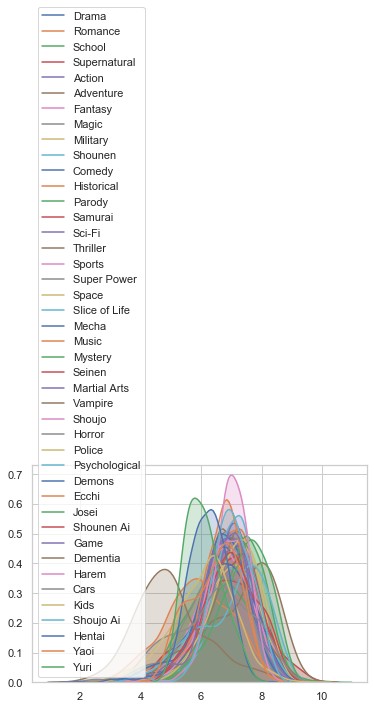

In [6]:
def genre_splitter(genre_names):
    return map(lambda x: x.strip(),genre_names.split(","))

def flatmap(f, items):
    return chain.from_iterable(map(f, items)) 

names = anime['name'];

m_uniq = anime['genre'].unique()

genres = pd.Series(list(flatmap(genre_splitter, m_uniq)))
genres1 = genres.append(pd.Series(['title']),ignore_index=True)
genres1 = genres1.unique()
genres = genres.unique()
#new_genres = list(genres)

rating_genre = pd.DataFrame(np.zeros((len(names),len(genres1))),index = names,columns=genres1)
rating_genre.head()
name_genre = rating_genre.copy()
titles = []
for item in anime.index.values:
    column = anime.loc[item , ['name', 'genre','rating'] ]
    listing = list(genre_splitter(column['genre']))
    for genre in listing:
        rating_genre.loc[column['name'], :][genre] = column['rating']
        name_genre.loc[column['name'], :][genre] = 1
    titles.append(column['name'])
    #name_genre.loc[column['name'], :]['title'] = "gaga" #column['name']
name_genre['title'] = titles;    
#rating_genre.head()
#name_genre.head()
ax = plt.subplot(111)

for genre in name_genre.columns:
    sns.kdeplot(anime[anime['genre'].str.contains(genre)]['rating'], shade=True, label = genre,ax = ax)


## Рейтинг (1 балл)

Постройте график, показывающий сколько оценок каждого рейтинга поставили пользователи из таблицы `ratings`.

In [7]:
grouped_rating = ratings.groupby(['rating']).count().reset_index()
#print(grouped_rating)

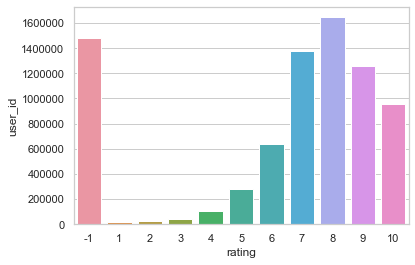

In [8]:
sns.barplot(x='rating',y='user_id',data=grouped_rating)

## Фильтрация данных (5 баллов)

Если мы сразу же построим кросстаб матрицу `anime` vs `user`, где в ячейках рейтинг, который поставил юзер этому фильму, то у нас это все займет около 6 гигабайт памяти. Можно значительно сократить размер матрицы, если выкинуть данные об аниме, которое почти никто не оценил и юзеров, которые почти ничего не оценивали.

Для этого постройте два новых датафрейма:

- anime_watches, где индексом является anime_name, а значением - количество его обзоров
- user_ratings, где индексом является user_id, а значением - количество вниме, которое он оценил.

Далее, соедините (join) 4 таблицы: ratings, anime, anime_watches, user_ratings и назовите новую таблицу anime_ratings.

Что означает `-1` в таблице рейтинга? Замените все -1 на средний рейтинг аниме.

Удалите из таблицы все те значения, у которых количество обзоров и рейтингов меньше медианного значения. То есть мы удалим половину аниме и половину юзеров.

In [9]:
anime_watches_data = ratings.groupby(['anime_id']).count().reset_index() 

anime_watches_data1 = list()
for id in anime.sort_index().index.values:
    try:    
        temp_index = anime_watches_data[anime_watches_data['anime_id'] == id].index.values
        if (len(temp_index) == 0):
            anime_watches_data1.append(0)
        else:
            how_much_watches = anime_watches_data.loc[temp_index[0]]['user_id']
            anime_watches_data1.append(how_much_watches)
    except Exception:
        anime_watches_data1.append(-1) 
anime_watches_index = anime.sort_index()['name']
anime_watches = pd.DataFrame(anime_watches_data1, index = anime_watches_index, columns = {"watch_count"})
anime_plus = anime.join(anime_watches, on= 'name')
#anime_plus.set_index(pd.Series([i+1 for i in np.arange(len(anime_plus))]))
anime_plus = anime_plus.reset_index()
#print(anime_plus.head())

user_ratings_data = [user for user in ratings.groupby(['user_id']).count().reset_index()['anime_id']]
user_ratings_index = ratings['user_id'].unique()
user_ratings = pd.DataFrame(user_ratings_data, index = user_ratings_index, columns = {'anime_count'})
ratings_plus = ratings.join(user_ratings, on='user_id')

anime_ratings = anime_plus.join(ratings_plus.set_index('anime_id'), on='anime_id',rsuffix='.right').reset_index(drop = True)
print(anime_ratings.head())

   anime_id            name                                 genre   type  \
0     32281  Kimi no Na wa.  Drama, Romance, School, Supernatural  Movie   
1     32281  Kimi no Na wa.  Drama, Romance, School, Supernatural  Movie   
2     32281  Kimi no Na wa.  Drama, Romance, School, Supernatural  Movie   
3     32281  Kimi no Na wa.  Drama, Romance, School, Supernatural  Movie   
4     32281  Kimi no Na wa.  Drama, Romance, School, Supernatural  Movie   

  episodes  rating  members  watch_count  user_id  rating.right  anime_count  
0        1    9.37   200630         2199     99.0           5.0        131.0  
1        1    9.37   200630         2199    152.0          10.0        143.0  
2        1    9.37   200630         2199    244.0          10.0        277.0  
3        1    9.37   200630         2199    271.0          10.0        599.0  
4        1    9.37   200630         2199    278.0          -1.0         44.0  


In [10]:
#for id in anime_watches_data['anime_id']:
#    try:
#        anime.loc[id,['name']].index
#    except Exception:
#        print("id {0} does not exist in anime, but exist in ratings".format(id))  
#print("\ndone with ratings\n")

anime_ratings['rating.right'][anime_ratings['rating.right'] == -1.0] = anime_ratings['rating'][anime_ratings['rating.right'] == -1.0]
print(len(anime_ratings))
#print(anime_ratings['watch_count'].unique())
watch_count_mean = anime_ratings['watch_count'].mean()
#print(watch_count_mean)
index_to_drop = anime_ratings.index[anime_ratings['watch_count'] < watch_count_mean].tolist()
#print(len(index_to_drop))
anime_ratings1 = anime_ratings.drop(index_to_drop)
print(len(anime_ratings1))
anime_count_mean = anime_ratings1['anime_count'].mean()
index_to_drop1 = anime_ratings1.index[anime_ratings1['anime_count'] < anime_count_mean].tolist()
print(len(index_to_drop1))
anime_ratings2 = anime_ratings1.drop(index_to_drop1)
print(len(anime_ratings2))
print(anime_ratings2.head())

/home/arcades/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


7814471
2809743
1830198
979545
      anime_id                              name  \
2203      5114  Fullmetal Alchemist: Brotherhood   
2208      5114  Fullmetal Alchemist: Brotherhood   
2210      5114  Fullmetal Alchemist: Brotherhood   
2213      5114  Fullmetal Alchemist: Brotherhood   
2241      5114  Fullmetal Alchemist: Brotherhood   

                                                  genre type episodes  rating  \
2203  Action, Adventure, Drama, Fantasy, Magic, Mili...   TV       64    9.26   
2208  Action, Adventure, Drama, Fantasy, Magic, Mili...   TV       64    9.26   
2210  Action, Adventure, Drama, Fantasy, Magic, Mili...   TV       64    9.26   
2213  Action, Adventure, Drama, Fantasy, Magic, Mili...   TV       64    9.26   
2241  Action, Adventure, Drama, Fantasy, Magic, Mili...   TV       64    9.26   

      members  watch_count  user_id  rating.right  anime_count  
2203   793665        24574     17.0          10.0        601.0  
2208   793665        24574     38.0    

## Матрица user-item (3 балла)

Превратите таблицу anime_ratings в матрицу, где в строках user_id, в стобцах anime_name, а в ячейках рейтинг. Посмотрите сколько занимет в памяти эта матрица.

In [11]:
def func_suck(columns,rows,anime_ratings2):
    #div = len(anime_ratings2.index.values)
    #i = 0
    #for i in range(div):
    #    rating = anime_ratings2.loc[anime_ratings2['user_id'] == columns[i],['name','rating.right']]
    #    print(i/div)
    #    for j in range(len(rows)):
    #       rating2 = rating.loc[rating['name'] == rows[j],['rating.right']]
    for index in anime_ratings2.index.values:
        #i+=1
        item = anime_ratings2.loc[index,['name','user_id','rating.right']]
        column_number = columns_dict[item['user_id']]
        row_number = rows_dict[item['name']]
        user_item[column_number][row_number] = item['rating.right']
        #print(i/div)
            

def some_func(x,user_item,columns_dict,rows_dict):
    #print(x)
    user_item[columns_dict[x['user_id']]][rows_dict[x['name']]] = x['rating.right']

columns = np.sort(anime_ratings2['user_id'].unique())
columns_dict = dict(zip(columns,np.arange(len(columns))))
#columns_dict = dict({1:columns[0]})
#print(columns_dict)
rows = np.sort(anime_ratings2['name'].unique())
rows_dict = dict(zip(rows,np.arange(len(rows))))
#print(rows_dict)
user_item = np.zeros([len(columns),len(rows)],dtype=float)
user_item -=1
#print(anime_ratings3.head())

#%time anime_ratings2.apply(some_func,args=(user_item,columns_dict,rows_dict,), axis = 1)

#for index in anime_ratings2.index.values:
#    item = anime_ratings2.loc[index,['name','user_id','rating.right']]
#    column_number = columns_dict[item['user_id']]
#    row_number = rows_dict[item['name']]
#   user_item[column_number][row_number] = item['rating.right']

# ~ 15 min
%time func_suck(columns_dict,rows_dict,anime_ratings2)
        #user_item[i][j] = rating
#print(user_item.shape)
#print(user_item)

CPU times: user 15min 5s, sys: 533 ms, total: 15min 5s
Wall time: 15min 5s


In [12]:
print("user_item size ~ {0} MB".format(user_item.nbytes / (1024**2)))
print(user_item.shape)

user_item size ~ 17.441322326660156 MB
(9181, 249)


## Понижение размерности (1 балл)

kNN будет плохо работать на многомерных данных, поэтому надо понизить размерности матрицы с помощью алгоритма PCA. Количество размерностей установите от 4 до 10 - как вам покажется оптимальнее. (можете это исправить когда запустите kNN и получите результаты).

In [13]:
pca = decomposition.PCA(n_components=6)
pca.fit(user_item)
data_pca = pca.transform(user_item)
print(data_pca)
print(user_item.shape)
print(data_pca.shape)

[[ -6.85168597 -25.06004385  -1.52922302  -6.23788174   0.50391881
    7.42865062]
 [ -5.1466888  -18.81312184 -13.51250267 -13.59473543 -14.15947845
    0.75103408]
 [ 16.68290528   1.57139861  31.20145775 -17.8584339  -15.40257946
   -6.70674789]
 ...
 [ 17.64518626  28.01869838 -16.18579329 -27.22886064   1.91006804
  -17.3375834 ]
 [-14.58564682  -5.69496377  19.95994392   8.28948981 -16.15686651
    3.82088394]
 [-36.20052364  21.00339917  -7.87516564  -5.26200666  -1.53534301
    6.4512317 ]]
(9181, 249)
(9181, 6)


## Обучение kMeans (1 балл)

Обучим kMeans, чтобы он нашел нам центры кластеров нашей выборки.

Так как в строках у нас user_id, то центры класетров - это будут характеристики пользователей в терминах их оценок аниме. Используя эту информацию мы можем вычислить список характерных аниме для конкретного кластера.

- обучите kMeans
- создайте копию матрицы и добавьте новую колонку - кластер. Положите в нее результат предсказания кластера для каждого пользователя. (метод predict)
- нарисуйте cout plot количества юзеров в каждом кластере. Если получается сильно неравномерное распределение, то вам надо подобрать другое количество кластеров или изменить размерность в предыдущем шаге.

In [ ]:
def create_cluster_row(columns_dict,predict_result,anime_ratings3):
    for key in columns_dict.keys():
        value = predict_result[columns_dict[key]]
        anime_ratings3.loc[anime_ratings3['user_id'] == key,['cluster']] = value
#was 10 clusters, now 8
%time k_means = KMeans(random_state=0,n_clusters=8,n_jobs=4).fit(data_pca)
predict_result = k_means.predict(data_pca)

#columns_dict_reverse = dict(zip(np.arange(len(columns)), columns))

anime_ratings3 = pd.DataFrame(anime_ratings2).reset_index(drop = True)
anime_ratings3.head()
anime_ratings3['cluster'] = -1

#~ 5min
%time create_cluster_row(columns_dict,predict_result,anime_ratings3)
anime_ratings3.head()



CPU times: user 64.4 ms, sys: 72 ms, total: 136 ms
Wall time: 2.23 s


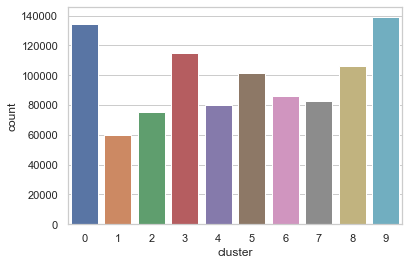

In [15]:
sns.countplot(x= 'cluster',data = anime_ratings3)

## Top 15 аниме (2 балла)

Найдем Top-15 аниме для каждого кластера. Для этого:

- найдите средний рейтинг аниме в каждом кластере. 
- для каждого кластера возьмите набор аниме с их средним рейтингом, отсортируйте этот набор по убыванию рейтинга. 
- возьмите первые 15 элементов из набора - это и будет топ15 аниме в кластере.
- согласны ли вы с содержимым кластера?

In [16]:
#grouped_cluster = anime_ratings3.groupedby(['cluster','name'])
#mean = grouped_cluster['rating.right'].mean()
anime_ratings3['rating.mean'] = 0
title_mean = list()
i = 0
lelen = len(anime_ratings3['cluster'].unique())
for cluster1 in anime_ratings3['cluster'].unique():
    i+=1
    item = anime_ratings3.loc[anime_ratings3['cluster'] == cluster1]
    cluster_ratings = list()
    for anime1 in item['name'].unique():
        title = item.loc[item['name'] == anime1]['rating.right'].mean()
        cluster_ratings.append(title)
        #print(title)
        anime_ratings3['rating.mean'].loc[anime_ratings3['name'] == anime1] = title
    cluster_ratings = np.array(cluster_ratings)
    cluster_ratings.sort()
    #print(cluster_ratings) 
    print("\n progress: {0} \n".format(i/lelen))    

/home/arcades/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


[6.03488778 6.21705882 6.52243056 6.58477064 6.63346705 6.6508
 6.66625    6.67172107 6.68723183 6.74724409 6.7568932  6.77821782
 6.78752    6.8244898  6.83649635 6.90694864 6.96079096 6.96154362
 6.99994565 7.02148148 7.05570048 7.06527778 7.09262136 7.10116279
 7.10480519 7.12399225 7.14670659 7.15111111 7.23044863 7.27016667
 7.27273224 7.28223602 7.28439153 7.28601266 7.28767742 7.31152174
 7.32309524 7.32503226 7.32823899 7.33379888 7.33666667 7.33670886
 7.33684211 7.33866667 7.33878453 7.34398437 7.35374545 7.35733945
 7.37352941 7.37937313 7.39839394 7.41471459 7.42124481 7.42333333
 7.43217391 7.43294702 7.43382514 7.43640719 7.44544474 7.45082474
 7.45274151 7.46924138 7.46949036 7.4822695  7.49324324 7.50857143
 7.51238636 7.52151899 7.52211268 7.5351963  7.53695324 7.54276224
 7.5443299  7.563125   7.56931359 7.58095506 7.58551136 7.58825746
 7.60058219 7.60571429 7.61663923 7.63456446 7.64178832 7.65206897
 7.65861507 7.66046667 7.66826156 7.6918018  7.6999031  7.70360656

[5.3498     5.52706587 5.63818182 5.64995781 5.83875969 5.85841346
 5.91204461 5.93267347 5.94723684 5.99127273 6.05374359 6.07568528
 6.09211268 6.12455056 6.15472868 6.15597015 6.20400943 6.21220657
 6.22614173 6.28169014 6.29447761 6.35342466 6.35960784 6.368
 6.37485714 6.43340611 6.44365079 6.46879177 6.47081081 6.48670659
 6.49425287 6.5064574  6.53333333 6.53767123 6.55854227 6.56833977
 6.5718894  6.59473282 6.59661538 6.59824268 6.60686981 6.61861736
 6.629225   6.64301413 6.65134921 6.65581395 6.65806818 6.68092105
 6.68462069 6.69242424 6.69794118 6.698125   6.70681548 6.70689655
 6.72134058 6.72182013 6.72619195 6.72774194 6.73002342 6.7313649
 6.73824228 6.73897638 6.75403636 6.76037647 6.764      6.76660156
 6.79788462 6.80355053 6.8434657  6.85319838 6.85433476 6.85832278
 6.87451673 6.8764613  6.88617778 6.88703863 6.90336449 6.91061453
 6.91913043 6.91917595 6.93597938 6.95370536 6.95957672 6.95980392
 6.970625   6.97657895 6.97832947 7.01414706 7.02724377 7.03106355
 

[6.65137324 6.84501062 6.85050279 6.87095128 6.9461512  6.95699288
 6.99884837 7.1058679  7.14249395 7.1703272  7.18324619 7.18878472
 7.19035897 7.20584475 7.25302326 7.29458333 7.29529623 7.29792531
 7.30826446 7.30928571 7.33255906 7.34643902 7.3518591  7.35371681
 7.365386   7.36798507 7.37793177 7.38715827 7.39459877 7.40885366
 7.41886435 7.42449749 7.42539877 7.42551661 7.43732984 7.47986992
 7.49697479 7.50392465 7.50478011 7.51644315 7.51774411 7.51969965
 7.53291045 7.53385827 7.53483871 7.53834034 7.53964948 7.55725522
 7.56069721 7.57111304 7.57431034 7.59159468 7.61434426 7.62737819
 7.63856427 7.64601671 7.65795455 7.661571   7.66725055 7.6747032
 7.70544861 7.71187151 7.71581845 7.71636975 7.71912664 7.73511335
 7.73618667 7.74172477 7.74326087 7.75806552 7.77176144 7.77548299
 7.77794872 7.7812749  7.79095355 7.79423168 7.8071799  7.81068702
 7.81517045 7.81623306 7.81972686 7.81983193 7.8222028  7.83201581
 7.84124272 7.84593373 7.85052342 7.85955983 7.86068376 7.86592

[6.5104712  6.57074468 6.6905618  6.86153061 6.87826087 6.936
 6.95182482 6.96485777 6.9874     7.00329457 7.04248879 7.07205128
 7.08169231 7.10204724 7.10693617 7.12111111 7.14691011 7.19207547
 7.19829787 7.20963753 7.22002725 7.2313089  7.23788732 7.25290323
 7.25335366 7.25847751 7.26368794 7.30033803 7.30146341 7.30224265
 7.3191358  7.34947368 7.35214286 7.365      7.368      7.37391304
 7.38333333 7.39377778 7.40990476 7.41027211 7.41978261 7.42162162
 7.42934959 7.42942308 7.42995781 7.43830918 7.44514563 7.4527931
 7.47471526 7.47508333 7.47797235 7.48129032 7.48935811 7.50062201
 7.5074     7.52268657 7.53642442 7.53684211 7.54490842 7.54683761
 7.54712644 7.55615385 7.55845842 7.5587234  7.56       7.56105263
 7.58318841 7.58677966 7.5907732  7.59619952 7.5974026  7.60613333
 7.61474453 7.61914894 7.624      7.65469484 7.65755396 7.67026316
 7.69575758 7.69913043 7.70129496 7.70808081 7.71899267 7.7208284
 7.72191011 7.72225989 7.74383784 7.76670051 7.76833922 7.76966614
 7

In [17]:
top = list()

for cluster1 in anime_ratings3['cluster'].unique():
    print("\n next \n")
    item = anime_ratings3.loc[anime_ratings3['cluster'] == cluster1,['name','rating.mean']]
    item_sorted = item.sort_values(by='rating.mean',ascending=False)
    #print(item_sorted.head())
    title = item_sorted['name'].drop_duplicates()
    top.append(title)
    #title = item.groupby(['name'])['rating.mean'].mean()
    print(title.head(15))


 next 

0              Fullmetal Alchemist: Brotherhood
16294                      Clannad: After Story
23685        Code Geass: Hangyaku no Lelouch R2
71816                     Great Teacher Onizuka
41543           Code Geass: Hangyaku no Lelouch
70994                Tengen Toppa Gurren Lagann
11825                               Steins;Gate
13344                    Hunter x Hunter (2011)
61185             Suzumiya Haruhi no Shoushitsu
109060                        Hellsing Ultimate
65112                                  Mushishi
55261                             Mononoke Hime
31825             Sen to Chihiro no Kamikakushi
134616    Evangelion: 2.0 You Can (Not) Advance
50484                             One Punch Man
Name: name, dtype: object

 next 

1              Fullmetal Alchemist: Brotherhood
17916                      Clannad: After Story
23825        Code Geass: Hangyaku no Lelouch R2
73302                     Great Teacher Onizuka
42620           Code Geass: Hangyaku no Lelo

## Top 5 жанров (2 балла)

Если соеднить таблицу с аниме с таблицей жанров, то можно найти топ жанров для каждого кластера. Придумайте сами как это сделать, так как тут много способов:

- найти средний рейтинг для аниме каждого жанра
- посчитать сколько представителей каждого жанра есть среди top100 аниме кластера (кстати работает лучше)
- ???

In [57]:
anime_ratings4 = anime_ratings3.join(name_genre, on = "name")
i = 0
lelen = len(anime_ratings4['cluster'].unique())
for cluster1 in anime_ratings4['cluster'].unique():
    item_sorted = anime_ratings4.loc[anime_ratings4['cluster'] == cluster1,['name','rating.mean',*genres]].sort_values(by='rating.mean',ascending=False)
    title = item_sorted.drop_duplicates(subset = 'name')    
    top_100 = title.head(100)
    top_100_sum = dict()
    for genre in genres:

        genre_sum = top_100[genre].sum()
        top_100_sum.update({genre: genre_sum})
    sum_series = pd.Series(top_100_sum).sort_values(ascending=False).head(5)
    print("Top 5 genres of anime in {0} cluster :\n{1}".format(i,sum_series))
    
    i+=1       


Top 5 genres of anime in 0 cluster :
Action          43.0
Comedy          39.0
Drama           33.0
Romance         30.0
Supernatural    30.0
dtype: float64
Top 5 genres of anime in 1 cluster :
Action          43.0
Comedy          39.0
Drama           33.0
Romance         30.0
Supernatural    30.0
dtype: float64
Top 5 genres of anime in 2 cluster :
Action          43.0
Comedy          39.0
Drama           33.0
Romance         30.0
Supernatural    30.0
dtype: float64
Top 5 genres of anime in 3 cluster :
Action          43.0
Comedy          39.0
Drama           33.0
Romance         30.0
Supernatural    30.0
dtype: float64
Top 5 genres of anime in 4 cluster :
Action          43.0
Comedy          39.0
Drama           33.0
Romance         30.0
Supernatural    30.0
dtype: float64
Top 5 genres of anime in 5 cluster :
Action          43.0
Comedy          39.0
Drama           33.0
Romance         30.0
Supernatural    30.0
dtype: float64
Top 5 genres of anime in 6 cluster :
Action          43.0
